In [1]:
import brightway2 as bw

In [5]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Libaries')

In [8]:
import sensitivity as st
import Monte_Carlo as mc
import reload_lib as rl

In [9]:
# Importing self-made libaries
import standards as s
import life_cycle_assessment as lc
import LCA_plots as lp
import box_plot as bp
import reload_lib as rl


lib = [s, mc, lc, lp, bp]

In [10]:
# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'
# Specifying the LCIA method
lcia_method = 'recipe'
lib = [st]
rl.reload_lib(lib)

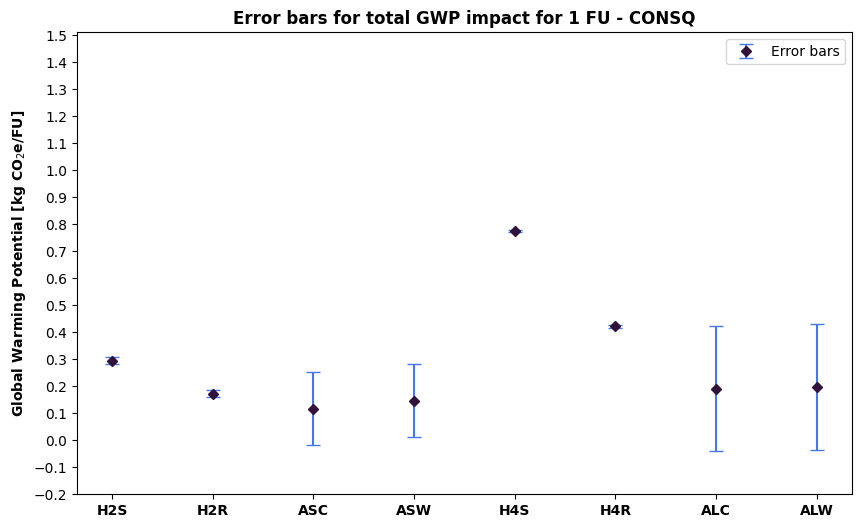

In [13]:
y_min = -0.2
y_max = 1.5
y_step = 0.1
y_offset = 0.01

y_axis = [y_min, y_max, y_step, y_offset]

try:
    st.uncertainty_graph(variables, lib, y_axis)
except NameError:
    database_name, df_GWP, db_type, database_name, flow_legend = st.break_even_initialization(path, lcia_method, lib)
    variables = [database_name, df_GWP, db_type, database_name, flow_legend]
    st.uncertainty_graph(variables, lib, y_axis)

In [12]:
flow_legend, database_name, file_name, sheet_name, save_dir, initialization, file_name_unique, db_type = lc.initilization(path, lcia_method)
# Setting up an empty dictionary with the flows as the key

project_name = initialization[0]
flows = initialization[2]
all_acts, eidb, eidb_db = lc.database_initialization(db_type, database_name, project_name)

procces_keys = {key: None for key in flows}

size = len(flows)

# Obtaining all the product codes for the process'
for act in all_acts:
    for proc in range(size):
        if act['name'] == flows[proc]:
            procces_keys[flows[proc]] = act['code']

procces_keys

ValueError: invalid literal for int() with base 10: ''

In [ ]:

for code in procces_keys.values():
    flow = bw.get_activity((database_name, code))
    uncertainty = flow.get('uncertainty', None)
    

    if uncertainty:
        print("Uncertainty Data:")
        print(f"Distribution type: {uncertainty['uncertainty type']}")
        print(f"Mean: {uncertainty.get('mean', 'N/A')}")
        print(f"Standard deviation: {uncertainty.get('standard deviation', 'N/A')}")
        print(f"Minimum: {uncertainty.get('minimum', 'N/A')}")
        print(f"Maximum: {uncertainty.get('maximum', 'N/A')}")
    else:
        print("No uncertainty data available for this flow.")

No uncertainty data available for this flow.
No uncertainty data available for this flow.
No uncertainty data available for this flow.
No uncertainty data available for this flow.
No uncertainty data available for this flow.
No uncertainty data available for this flow.
No uncertainty data available for this flow.
No uncertainty data available for this flow.
